In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.ndimage import rotate

import os
import random

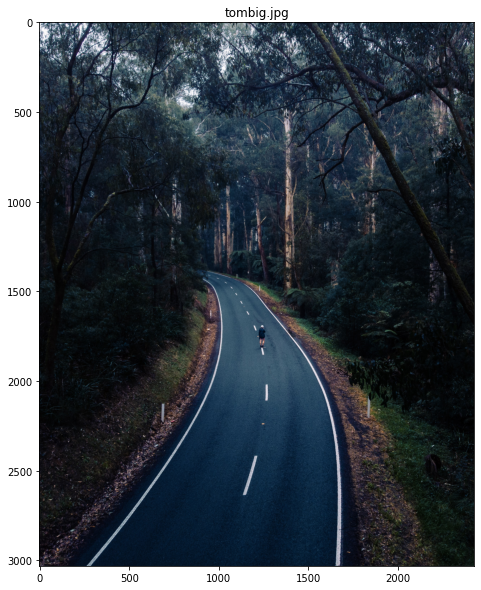

In [5]:
# load some image from data
image_path = random.choice(os.listdir("../data"))
img = np.asarray(Image.open(f"../data/{image_path}").convert("RGB"))
plt.figure(figsize=(10, 10))
plt.title(image_path)
plt.imshow(img)

In [6]:
def generate_random_gcps(img, num_samples, padding=(0, 0)):
    return np.random.randint(padding, 
                            high=(img.shape[0] - padding[0], img.shape[1] - padding[1]),
                            size=(num_samples, 2))

In [7]:
output_dim = (200, 200)
diag_len = np.ceil(np.sqrt(output_dim[0] ** 2 + output_dim[1] ** 2))
gcps = generate_random_gcps(img, 10, padding=(diag_len, diag_len))
gcps

array([[2472, 2047],
       [1044, 1617],
       [2311,  661],
       [2125,  772],
       [1042, 1250],
       [2295,  814],
       [2017, 1986],
       [1001, 1050],
       [1402, 1008],
       [1452,  347]])

In [8]:
def crop_around(img, centers, dim):
    x = centers.T[1] - dim[1] // 2
    y = centers.T[0] - dim[0] // 2
    return [img[p[0]:p[0]+dim[0], p[1]:p[1]+dim[1]] for p in zip(y, x)]

In [9]:
def center_crop(img, dim):
    return img[img.shape[0] // 2 - dim[0] // 2:img.shape[0] // 2 + dim[0] // 2,
               img.shape[1] // 2 - dim[1] // 2:img.shape[1] // 2 + dim[1] // 2]

## GDAL Functions

In [10]:
from osgeo import gdal
from osgeo import ogr
from osgeo import osr

In [11]:
## Dataset used for mocking GPS coordinates

dataset_path = 'images/Copy of Blore_Clean.tif'
ds = gdal.Open(dataset_path)

In [12]:
# transformation described here: https://arijolma.org/Geo-GDAL/2.0/classGeo_1_1GDAL_1_1GeoTransform.html#details

# NOTE: pixel coordinate (0, 0) is the top left pixel of the image

def transform_pixel_coords_to_projection_coords(gt, column, row):
    a,b,c,d,e,f = gt
    x = a + column * b + row * c
    y = d + column * e + row * f
    
    return x,y

In [13]:
# Transforms pixel coordinate (column, row) of dataset to WGS84 geographic coordinates

def transform_image_pixel_coords_to_WGS84_geographic_coords(ds, row, column):
    # Input coordinate system: specified in input tif file
    InSR = osr.SpatialReference()
    InSR.ImportFromWkt(ds.GetProjectionRef())
    
    # Output coordinate system: WGS84/Geographic
    OutSR = osr.SpatialReference()
    OutSR.ImportFromEPSG(4326)
    
    # get pixel width and height of image
    width = ds.RasterXSize 
    height = ds.RasterYSize 
    
    # transformation from pixel coordinates to projection coordinates
    gt = ds.GetGeoTransform()
    
    # Transform top left pixel coordinate (0, 0) to projection coordinates
    x,y = transform_pixel_coords_to_projection_coords(gt, row, column)
    
    # transformation from projection coordinates to WGS84 geographic coordinates
    transform = osr.CoordinateTransformation(InSR, OutSR)
    
    # geographic latitude and longitude of point
    latlong = transform.TransformPoint(x,y)
    
    latitude, longitude = latlong[:2]
    
    return latitude, longitude

## Path building

In [14]:
def build_path(input_img, gcps, sample_dim, with_imgs=True):
    delta = np.diff(gcps, axis=0)
    directions = delta / np.linalg.norm(delta, axis=1).reshape(-1, 1)
    angles = np.arctan2(directions.T[1], directions.T[0]) * 180 / np.pi
    delta_angles = np.append(np.diff(angles), 0)

    sample_diag = np.floor(np.sqrt(sample_dim[0] ** 2 + sample_dim[1] ** 2)).astype("uint32")
    path = []

    if with_imgs:
        path_imgs = []
    
    for t1, t2, angle, delta_angle in zip(gcps, gcps[1:], angles, delta_angles):
        steps = np.linalg.norm(t2 - t1) / 90  # segment_length / pixels_per_shot
        line = np.linspace(t1, t2, steps.astype('uint32'), dtype="uint32")
        
        for (x, y) in line:
            latitude, longitude = transform_image_pixel_coords_to_WGS84_geographic_coords(ds, x, y)
            path.extend([np.array([x, y, angle, latitude, longitude])])

        if not with_imgs:
            continue

        # create image samples with appropriate rotation
        sample = crop_around(input_img, line, (sample_diag, sample_diag))
        rotated_sample = [center_crop(rotate(s, -angle, reshape=False), sample_dim) for s in sample]
        path_imgs.extend(rotated_sample)

        if delta_angle == 0:
            continue
    
        # end of segment, mock changing direction in place
        interpolated_angles = np.linspace(angle, angle + delta_angle, 3)
        
        for theta in interpolated_angles:
            end_x, end_y = line[-1][0], line[-1][1]
            latitude, longitude = transform_image_pixel_coords_to_WGS84_geographic_coords(ds, end_x, end_y)
            path.extend([np.array([end_x, end_y, theta, latitude, longitude])])
        
#         path.extend([np.array([line[-1][0], line[-1][1], theta, *transform_image_pixel_coords_to_WGS84_geographic_coords(ds, line[-1][0], line[-1][1])]) for theta in interpolated_angles])
        path_imgs.extend([center_crop(rotate(sample[-1], -theta, reshape=False), sample_dim) for theta in interpolated_angles])
    
    return np.array(path), np.array(path_imgs)


In [15]:
trace, imgs = build_path(img, gcps, output_dim)

In [16]:
trace[280:305, 2]

array([], dtype=float64)

In [17]:
np.unique(trace[:, 2], return_index=True)

(array([-163.24187766, -137.34687429, -137.34687429, -100.13891432,
         -85.6742153 ,  -71.6630639 ,  -45.82673441,  -37.03595098,
         -19.18610194,  -19.18610194,  -17.00142692,   -5.97925351,
          -5.97925351,   42.07895925,   56.06819336,   68.49941882,
         103.34402045,  149.1723377 ,  152.67863864,  156.18493959]),
 array([  0,  93,  92,  17, 117, 109, 116,  18,  59,  60,  91, 111, 110,
         75,  37,  58,  76,  38,  42,  43]))

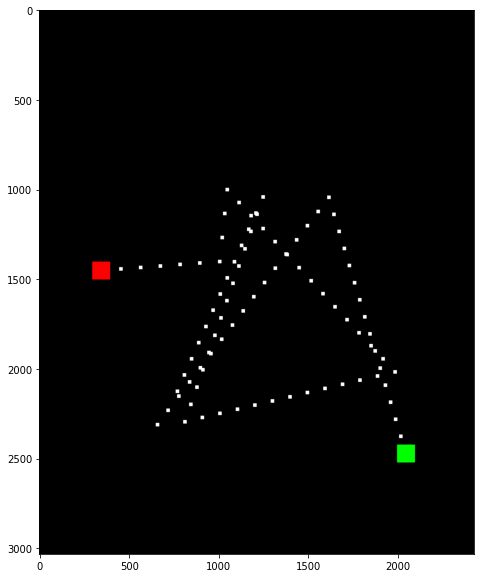

In [18]:
path_trace = np.zeros(img.shape)
for x, y, _, _, _ in trace:
    x = int(x)
    y = int(y)
    path_trace[x-10:x+10, y-10:y+10] = 1

x_start, y_start, _, _, _ = trace[0].astype("uint32")
x_end, y_end, _, _, _ = trace[-1].astype("uint32")
path_trace[x_start-50:x_start+50, y_start-50:y_start+50] = np.array([0, 1, 0])
path_trace[x_end-50:x_end+50, y_end-50:y_end+50] = np.array([1, 0, 0])

plt.figure(figsize=(10, 10))
plt.imshow(path_trace)

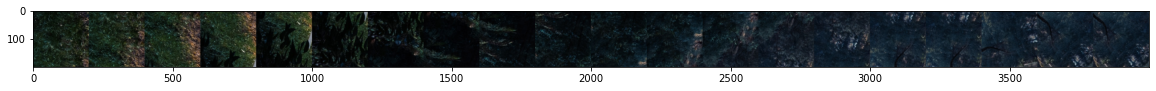

In [19]:
plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(imgs[:20]))